## Implementing MLPs with Keras


### Setting Up Your Environment

- Before diving into implementing Multi-Layer Perceptrons (MLPs) with Keras, ensure you've set up your virtual environment.
- If you haven't already installed TensorFlow and scikit learn, use the command `pip install -U tensorflow` and `pip install -U scikit-learn` respectively to get them installed.
- `-U` or `--upgrade` here instructs pip to install the latest version of the package.
- The chosen backend API for TensorFlow is Keras, which also extends support to other deep learning libraries such as PyTorch.

In [1]:
# to check if the package is installed and its version, you can-

import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.13.0


### Choosing the dataset

For this blog, we'll use the MNIST dataset, often referred to as the "hello world" of machine learning for classification tasks. It consists of 70,000 instances, each having 784 features representing pixel values ranging from 0 to 1. If you reshape these values into a 28x28 array and use Matplotlib's imshow function, you'll see images of handwritten numbers. The goal is to classify each instance into its actual label, which ranges from 0 to 9.

- Just like MNIST the Fashion MNIST which is provided by the utility functions of the tensorflow is a similar kind of dataset.
- It has the exact same format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes, but here the task is to clasify fashion items and not the handwritten digits.
- Lets load the dataset using keras. 
    - It's worth mentioning that the dataset is already split into test and train sets but not validation sets, the same will be implemented below. 
- This would take significant amount of time depending on your internet connection speed. 



In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train_full, y_train_full), (x_test, y_test) = fashion_minst.load_data()

In [13]:
# once data loaded it would be better if you save to local disk as a dict or an npy, instead of re-downloading every time you restart
# here is a code snippet to do that

import numpy as np

try:
    data = np.load(r'data\fashion_mnist_data.npy', allow_pickle=True).item() 
    print("data loaded")
    
except FileNotFoundError:
    user = input("download fashion mnist data? [y/n]: ")
    if user.lower() == 'y':
        (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
        data = {
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test, 
            'y_test': y_test
        }
    
        np.save('data\fashion_mnist_data.npy', data)
        print("data saved")

data loaded


In [4]:
# as said above the fashion mnist contains fashion items and here are those

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

### Creating the model using Sequential API

##### Here's a breakdown of the model creation using the Sequential API:

- Line 1: We create a sequential model, the simplest form of a neural network composed of a single stack of layers.


- Line 2: this is the input layer, the role of this layer is to flatten the 2D array to 1D array. Since its the first layer you should specify the input shape, if you are not aware of it API will wait till the data is fitted and the when the training starts it would watch the first batch of the data and then determines the input shape by itself. If its overwhelming, you can also do it this way -

        
           model.add(keras.layers.Input(shape=[28, 28]))
           model.add(keras.layers.Flatten())
  
  
- Line 3: Next we add the dense hidden layer of 300 neurons with an activation function ReLU, each of the dense layers maintails a matrix of its own weights and a vector of bias terms for each neuron.


- Line 4: The second dense hidden layer with 100 neurons follows, also utilizing the ReLU activation function.


- Line 5: Finally we add a output layer which also happens to be dense with 10 neurons since we have 10 classes meaning one neuron for each. Since its a multi label classfication we use `sofmax` activation function, if it was binary clasification we would have used `sigmoid` activation

In [5]:
from keras import Sequential
tf.random.set_seed(42)

model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [6]:
# Diffrent approach. The same can also be done this way, its more convineient

model = Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, 'relu'),
    keras.layers.Dense(100, 'relu'),
    keras.layers.Dense(10, 'softmax')
])

### Exploring the model

Now model contains a attribute called `summary` which stores information of all the layers and their weights. None here represents batch size sunce we did not explicitly define the batch size, its None for now.

In [8]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 300)               235500    
                                                                 
 dense_16 (Dense)            (None, 100)               30100     
                                                                 
 dense_17 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name.
And also there are ways to get the models weight matrix and bias vector, there is also a `set_weights` method using which, you can set the weights.

In [12]:
# get model list of layers
model.layers

# access layer by its index 
hidden1 = model.layers[1]
hidden1.name

# access layer by its name
model.get_layer('dense_15')

# access model parameters
weights, biases = hidden1.get_weights()
print(weights.shape, biases.shape)

(784, 300) (300,)


### Compiling the model

Prior to exposing the model to data, it's crucial to compile it. This involves defining the learning rate, loss function, and metrics.


We use the `sparse_categorical_crossentropy` since we have only one target class per instance i.e 0 to 9 which is sparse, 
if instead we had one target probability per class (`eg. [0, 0 , 0, 1, 0, 0, 0, 0, 0]`) which are called `one-hot vectors` we would have used `categorical_crossentropy`.

The `optimizer="sgd"` indicates that the model will be trained using Stochastic Gradient Descent. You can set the learning rate using `optimizer=keras.optimizers.SGD(lr=???)`. 

The lr when `optimizer="sgd"` used defaults to 0.01

In [38]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

### Preparing data

Since we've previously downloaded the data and saved it in JSON format, we'll now load it in a similar manner.


Although the fashion_mnist dataset was already split into train and test sets, we need to create validation sets now.


Validation data is vital for monitoring model performance during training. If the training accuracy surpasses the validation accuracy, it signals overfitting, and vice versa indicates underfitting. 

We'll allocate 5,000 instances to the validation set.


In [26]:
x_train_full, y_train_full, x_test, yTest = data['x_train'], data['y_train'], data['x_test'], data['y_test']
x_train, y_train = x_train_full[:55000], y_train_full[:55000]
x_valid, y_valid = x_train_full[55000:], y_train_full[55000:]

### Training and evaluating the model


With the model primed for training, invoking the fit method will accomplish the task. Provide the train and validation sets, along with the number of epochs.


Keras evaluates loss and metrics on this set at the end of each epoch, offering valuable insights into the model's performance.


Here each epoch goes through 1719 batches, since the default batch size is 32. So, if we do the maths we understand that model goes through 1718 batches of size 32 and 1 batch of size 24 which would equal to 55k

Upon completing training, it's advisable to save the model for future use. Later you can load using

`model = keras.models.load_model("models\mnist_model.keras")`

In [27]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid))
model.save('mnist_model.keras')

Epoch 1/30
1719/1719 [==============================] - 13s 6ms/step - loss: 0.2559 - accuracy: 0.9050 - val_loss: 0.4398 - val_accuracy: 0.8592
Epoch 2/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2539 - accuracy: 0.9048 - val_loss: 0.4325 - val_accuracy: 0.8590
Epoch 3/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2502 - accuracy: 0.9065 - val_loss: 0.4178 - val_accuracy: 0.8684
Epoch 4/30
1719/1719 [==============================] - 9s 6ms/step - loss: 0.2480 - accuracy: 0.9080 - val_loss: 0.4336 - val_accuracy: 0.8624
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2445 - accuracy: 0.9079 - val_loss: 0.4198 - val_accuracy: 0.8650
Epoch 6/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2421 - accuracy: 0.9100 - val_loss: 0.4419 - val_accuracy: 0.8636
Epoch 7/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2411 - accuracy: 0.9100 - val_loss: 0.4418 - val_accura

### Results


When dealing with a skewed training set, where certain classes are overrepresented and others underrepresented, consider using the `class_weights` argument when calling the fit method. Keras will manage this aspect. Otherwise, the final results may lack reliability.


The fit() method returns a History object encompassing training parameters, epochs, and a dictionary (history.history) containing loss and additional metrics for both training and validation sets. You can convert this dictionary into a Pandas DataFrame and use its plot() method to visualize learning curves.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

<Axes: xlabel='Epochs'>

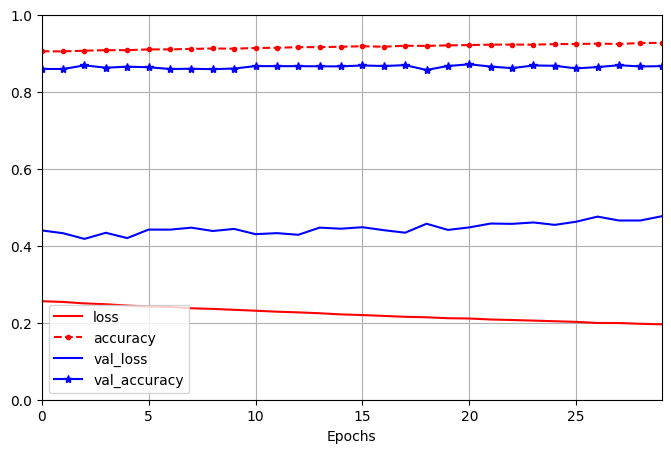

In [32]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], xlabel="Epochs", grid=True,
    style=['r-', 'r--.', 'b-', 'b-*'])

In [33]:
# now you should check how the model performs on unseen data (test data)

model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4943 - accuracy: 0.8682


[0.49430614709854126, 0.8682000041007996]

### Making Predictions

In [41]:
# get probabilities for some of the instances
x_new = x_test[:5]
y_probabilities = model.predict(X_new)
y_probabilities.round(2)

y_predictions = y_probabilities.argmax(axis=-1)

print("Predictions")
print("Class Labels:", y_predictions)

print("Class Names:", np.array(class_names)[y_predictions])

1/1 [==============================] - 0s 50ms/step
Predictions
Class Labels: [9 2 1 1 6]
Class Names: ['Ankle boot' 'Pullover' 'Trouser' 'Trouser' 'Shirt']


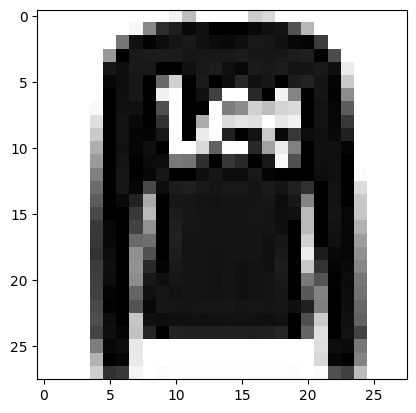

In [38]:
fig = plt.imshow(x_new[0], cmap='binary')

### Conclusion

As you can see the implemenation of `sequential-api` is although easy and straight forward, it cannont be used to build complex models. For this purpose keras offers `functional-api`.